In [1]:
import pandas as pd
import numpy as np
from models.BinaryMI import BinaryMI
from models.DebiasClassifier import DebiasClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import rc, rcParams
from matplotlib.collections import LineCollection
from scipy.interpolate import UnivariateSpline
import random

In [2]:
# The label ‘signal’ being ‘1’ for signal events, ‘0’ for background events
# the signal events are simulated, while background events are real data.
training = pd.read_csv("data/training.csv")
# The test dataset has all the columns that training.csv has, except
# mass, production, min_ANNmuon, and signal.
test = pd.read_csv("data/test.csv")
# Simulated and real events from the channel Ds → φπ to evaluate
# the performance for simulated-real data
# It contains the same columns as test.csv and weight column. 
agreement = pd.read_csv("data/check_agreement.csv")
# Only real background events recorded at LHCb to evaluate
# the mass values locally.
# It contains the same columns as test.csv and mass column to check correlation
correlation = pd.read_csv("data/check_correlation.csv")

In [3]:
# simulation (source) (signal==1) contains 8205 examples 
# real data (target) (signal==0) contains 322942 examples with weight values
counts = np.unique(agreement["signal"], return_counts=True)
counts_train = np.unique(training["signal"], return_counts=True)

print(f"Agreement data # source domain: {counts[1][1]}, # target domain: {counts[1][0]}")
print(f"Training data # source domain: {counts_train[1][1]}, # target domain: {counts_train[1][0]}")

Agreement data # source domain: 8205, # target domain: 322942
Training data # source domain: 41674, # target domain: 25879


In [4]:
# prepare the data

# split the data for agreement test at the end
agreement_train, agreement_test = \
    train_test_split(agreement, test_size=0.666)

# we take equal values from both groups
agreement_train_s0 = agreement_train[agreement_train["signal"]==0].sample(n=int(len(agreement_train[agreement_train["signal"]==1])/2))
agreement_train_s1 = agreement_train[agreement_train["signal"]==1].sample(n=int(len(agreement_train[agreement_train["signal"]==1])/2))
agreement = pd.concat([agreement_train_s0, agreement_train_s1])

# prepare the data for the domain adaptation task
s = np.concatenate([agreement_train["signal"].to_numpy(), training["signal"].to_numpy()])
agreement_train = agreement_train.drop(columns=["id", "signal", "SPDhits", "weight"], axis = 1)

# from the agreement data we only have background so y=0
y = np.concatenate([np.zeros(len(agreement_train)), training["signal"].to_numpy()])

# Note: for this example we dont use the mass
# mass_train = training["mass"]

# create the features to train on
x = training.drop(columns=["id", "production", "min_ANNmuon", "signal", "mass", "SPDhits"], axis = 1)
x = pd.concat([agreement_train, x], ignore_index=True)

# split the data into train and test set
X_train, X_test, y_train, y_test, S_train, S_test = \
    train_test_split(x, y, s, test_size=0.333)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# train the transfer model
BMI = BinaryMI(
    kernel_regularizer = 0.0,
    batch_size=32,
    hidden_layers = [64,32],
    validation_size=0.1,
    quantized_position=[True, False],
    input_shape=(X_train.shape[1],),
    verbose=1,
    learning_rate_decay_rate=0.001,
    gamma=0.3,
    print_summary=True,
    last_layer_size=2,
    run_eagerly=False
)
train_hist_BMI = BMI.fit(x_train=X_train, y_train=y_train, s_train=S_train)

Model: "BinaryMI"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x (InputLayer)                  │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_0 (Dense)                     │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ qact_t_0 (QActivation)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_1 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_2 (Dense)                     │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,090 (19.88 KB)

 Trainable params: 5,090 (19.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 2s 491us/step - loss: 0.5219 - qact_t_0_acc: 0.7097 - t_2_acc: 0.7753 - val_loss: 0.4545 - val_qact_t_0_acc: 0.7195 - val_t_2_acc: 0.8224
Epoch 2/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - loss: 0.4559 - qact_t_0_acc: 0.7156 - t_2_acc: 0.8262 - val_loss: 0.4401 - val_qact_t_0_acc: 0.7239 - val_t_2_acc: 0.8330
Epoch 3/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step - loss: 0.4474 - qact_t_0_acc: 0.7192 - t_2_acc: 0.8300 - val_loss: 0.4407 - val_qact_t_0_acc: 0.7213 - val_t_2_acc: 0.8355
Epoch 4/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 0.4445 - qact_t_0_acc: 0.7190 - t_2_acc: 0.8349 - val_loss: 0.4332 - val_qact_t_0_acc: 0.7193 - val_t_2_acc: 0.8373
Epoch 5/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 0.4390 - qact_t_0_acc: 0.7164 - t_2_acc: 0.8361 - val_loss: 0.4340 - val_qact_t_0_acc: 0.7204 - val_t_2_acc: 0.8361
Epoch 6/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step - loss: 0.4390 - qact_t_0_acc: 0.7149 - t_2_

In [6]:
# train a simple NN
NN = BinaryMI(
    kernel_regularizer=0.0,
    batch_size=32,
    hidden_layers=[64,32],
    validation_size=0.1,
    quantized_position=[True, False],
    input_shape=(X_train.shape[1],),
    verbose=1,
    gamma=0.0,
    print_summary=True,
    last_layer_size=2,
    run_eagerly=False
)
train_hist_NN = NN.fit(x_train=X_train, y_train=y_train, s_train=S_train)

Model: "BinaryMI"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x (InputLayer)                  │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_0 (Dense)                     │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ qact_t_0 (QActivation)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_1 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_2 (Dense)                     │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,090 (19.88 KB)

 Trainable params: 5,090 (19.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 2s 447us/step - loss: 0.3984 - qact_t_0_acc: 0.7343 - t_2_acc: 0.8093 - val_loss: 0.3290 - val_qact_t_0_acc: 0.7402 - val_t_2_acc: 0.8473
Epoch 2/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - loss: 0.3319 - qact_t_0_acc: 0.7363 - t_2_acc: 0.8474 - val_loss: 0.3223 - val_qact_t_0_acc: 0.7377 - val_t_2_acc: 0.8521
Epoch 3/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - loss: 0.3226 - qact_t_0_acc: 0.7378 - t_2_acc: 0.8544 - val_loss: 0.3243 - val_qact_t_0_acc: 0.7418 - val_t_2_acc: 0.8545
Epoch 4/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step - loss: 0.3208 - qact_t_0_acc: 0.7321 - t_2_acc: 0.8553 - val_loss: 0.3212 - val_qact_t_0_acc: 0.7374 - val_t_2_acc: 0.8550
Epoch 5/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - loss: 0.3204 - qact_t_0_acc: 0.7314 - t_2_acc: 0.8557 - val_loss: 0.3201 - val_qact_t_0_acc: 0.7368 - val_t_2_acc: 0.8530
Epoch 6/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - loss: 0.3195 - qact_t_0_acc: 0.7328 - t_2_

In [19]:
# train a DebiasClassifier
DCls = DebiasClassifier(
    kernel_regularizer=0.0,
    batch_size=32,
    validation_size=0.1,
    hidden_layers=[64,32],
    learning_rate_decay_rate=0.001,
    bias_layers=[10],
    verbose=1,
    gamma=0.2,
    print_summary=True,
    run_eagerly=False
)
train_hist_DCls = DCls.fit(x=X_train, y=y_train, s=S_train)

Model: "nn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nn_nn_0 (Dense)                 │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nn_nn_1 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,024 (19.62 KB)

 Trainable params: 5,024 (19.62 KB)

 Non-trainable params: 0 (0.00 B)

Model: "DebiasClassifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x0 (InputLayer)     │ (None, 45)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nn (Functional)     │ (None, 32)        │      5,024 │ x0[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grad_reverse_1      │ (None, 32)        │          0 │ nn[0][0]          │
│ (GradReverse)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nn_bias_0 (Dense)   │ (None, 10)        │        330 │ grad_reverse_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_part (Dense)    │ (None, 1)         │         33 │ nn[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nn_out_bias (Dense) │ (None, 1)         │         11 │ nn_bias_0[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,398 (21.09 KB)

 Trainable params: 5,398 (21.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 3s 533us/step - cls_part_AUC: 0.9040 - loss: 0.3436 - nn_out_bias_acc: 0.7950 - val_cls_part_AUC: 0.9452 - val_loss: 0.2576 - val_nn_out_bias_acc: 0.8833
Epoch 2/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - cls_part_AUC: 0.9514 - loss: 0.2406 - nn_out_bias_acc: 0.8883 - val_cls_part_AUC: 0.9565 - val_loss: 0.2357 - val_nn_out_bias_acc: 0.8920
Epoch 3/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - cls_part_AUC: 0.9610 - loss: 0.2178 - nn_out_bias_acc: 0.8989 - val_cls_part_AUC: 0.9607 - val_loss: 0.2245 - val_nn_out_bias_acc: 0.8961
Epoch 4/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - cls_part_AUC: 0.9654 - loss: 0.2061 - nn_out_bias_acc: 0.9047 - val_cls_part_AUC: 0.9635 - val_loss: 0.2170 - val_nn_out_bias_acc: 0.8998
Epoch 5/10
3343/3343 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - cls_part_AUC: 0.9684 - loss: 0.1980 - nn_out_bias_acc: 0.9083 - val_cls_part_AUC: 0.9656 - val_loss: 0.2110 - val_nn_out_bias_acc: 0.9008
Epoch 6/10
3343/3343

In [8]:
# following code is based on: https://www.kaggle.com/code/matteomonzali/nn-model

def __rolling_window(data, window_size):
    """
    Rolling window: take window with definite size through the array

    :param data: array-like
    :param window_size: size
    :return: the sequence of windows

    Example: data = array(1, 2, 3, 4, 5, 6), window_size = 4
        Then this function return array(array(1, 2, 3, 4), array(2, 3, 4, 5), array(3, 4, 5, 6))
    """
    shape = data.shape[:-1] + (data.shape[-1] - window_size + 1, window_size)
    strides = data.strides + (data.strides[-1],)
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


def __cvm(subindices, total_events):
    """
    Compute Cramer-von Mises metric.
    Compared two distributions, where first is subset of second one.
    Assuming that second is ordered by ascending

    :param subindices: indices of events which will be associated with the first distribution
    :param total_events: count of events in the second distribution
    :return: cvm metric
    """
    target_distribution = np.arange(1, total_events + 1, dtype='float') / total_events
    subarray_distribution = np.cumsum(np.bincount(subindices, minlength=total_events), dtype='float')
    subarray_distribution /= 1.0 * subarray_distribution[-1]
    return np.mean((target_distribution - subarray_distribution) ** 2)


def compute_cvm(predictions, masses, n_neighbours=200, step=50):
    """
    Computing Cramer-von Mises (cvm) metric on background events: take average of cvms calculated for each mass bin.
    In each mass bin global prediction's cdf is compared to prediction's cdf in mass bin.

    :param predictions: array-like, predictions
    :param masses: array-like, in case of Kaggle tau23mu this is reconstructed mass
    :param n_neighbours: count of neighbours for event to define mass bin
    :param step: step through sorted mass-array to define next center of bin
    :return: average cvm value
    """
    predictions = np.array(predictions)
    masses = np.array(masses)
    assert len(predictions) == len(masses)

    # First, reorder by masses
    predictions = predictions[np.argsort(masses)]

    # Second, replace probabilities with order of probability among other events
    predictions = np.argsort(np.argsort(predictions, kind='mergesort'), kind='mergesort')

    # Now, each window forms a group, and we can compute contribution of each group to CvM
    cvms = []
    for window in __rolling_window(predictions, window_size=n_neighbours)[::step]:
        cvms.append(__cvm(subindices=window, total_events=len(predictions)))
    return np.mean(cvms)


def __roc_curve_splitted(data_zero, data_one, sample_weights_zero, sample_weights_one):
    """
    Compute roc curve

    :param data_zero: 0-labeled data
    :param data_one:  1-labeled data
    :param sample_weights_zero: weights for 0-labeled data
    :param sample_weights_one:  weights for 1-labeled data
    :return: roc curve
    """
    labels = [0] * len(data_zero) + [1] * len(data_one)
    weights = np.concatenate([sample_weights_zero, sample_weights_one])
    data_all = np.concatenate([data_zero, data_one])
    fpr, tpr, _ = roc_curve(labels, data_all, sample_weight=weights)
    return fpr, tpr


def compute_ks(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.

    :param data_prediction: array-like, real data predictions
    :param mc_prediction: array-like, Monte Carlo data predictions
    :param weights_data: array-like, real data weights
    :param weights_mc: array-like, Monte Carlo weights
    :return: ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = np.array(data_prediction), np.array(mc_prediction)
    weights_data, weights_mc = np.array(weights_data), np.array(weights_mc)

    assert np.all(data_prediction >= 0.) and np.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert np.all(mc_prediction >= 0.) and np.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= np.sum(weights_data)
    weights_mc /= np.sum(weights_mc)

    fpr, tpr = __roc_curve_splitted(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = np.max(np.abs(fpr - tpr))
    return Dnm


def roc_auc_truncated(labels, predictions, tpr_thresholds=(0.2, 0.4, 0.6, 0.8),
                      roc_weights=(4, 3, 2, 1, 0)):
    """
    Compute weighted area under ROC curve.

    :param labels: array-like, true labels
    :param predictions: array-like, predictions
    :param tpr_thresholds: array-like, true positive rate thresholds delimiting the ROC segments
    :param roc_weights: array-like, weights for true positive rate segments
    :return: weighted AUC
    """
    assert np.all(predictions >= 0.) and np.all(predictions <= 1.), 'Data predictions are out of range [0, 1]'
    assert len(tpr_thresholds) + 1 == len(roc_weights), 'Incompatible lengths of thresholds and weights'
    fpr, tpr, _ = roc_curve(labels, predictions)
    area = 0.
    tpr_thresholds = [0.] + list(tpr_thresholds) + [1.]
    for index in range(1, len(tpr_thresholds)):
        tpr_cut = np.minimum(tpr, tpr_thresholds[index])
        tpr_previous = np.minimum(tpr, tpr_thresholds[index - 1])
        area += roc_weights[index - 1] * (auc(fpr, tpr_cut, reorder=True) - auc(fpr, tpr_previous, reorder=True))
    tpr_thresholds = np.array(tpr_thresholds)
    # roc auc normalization to be 1 for an ideal classifier
    area /= np.sum((tpr_thresholds[1:] - tpr_thresholds[:-1]) * np.array(roc_weights))
    return area

In [20]:
# get model performance
pre_bmi = BMI.predict_proba(X_test)
pre_nn = NN.predict_proba(X_test)
pre_DCls = DCls.predict_proba(X_test)
print(f"AUC BMI: {roc_auc_score(y_test, pre_bmi[:,1])}")
print(f"AUC NN: {roc_auc_score(y_test, pre_nn[:,1])}")
print(f"AUC DCls: {roc_auc_score(y_test, pre_DCls)}")

1854/1854 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step
AUC BMI: 0.899475399676374
AUC NN: 0.9082645716906479
AUC DCls: 0.9705352611690119


In [21]:
# prepare agreement data
agreement_weight = agreement_test["weight"]
agreement_signal = agreement_test["signal"]
agreement_test_feature = agreement_test.drop(columns=["id", "signal", "SPDhits", "weight"])

agreement_probs_BMI = BMI.predict_proba(agreement_test_feature)
agreement_probs_NN = NN.predict_proba(agreement_test_feature)
agreement_probs_DCls = DCls.predict_proba(agreement_test_feature)

6892/6892 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step


In [22]:
ks_bmi = compute_ks(
    agreement_probs_BMI[:,1][agreement_signal == 0],
    agreement_probs_BMI[:,1][agreement_signal == 1],
    agreement_weight[agreement_signal == 0],
    agreement_weight[agreement_signal == 1]
)

ks_nn = compute_ks(
    agreement_probs_NN[:,1][agreement_signal == 0],
    agreement_probs_NN[:,1][agreement_signal == 1],
    agreement_weight[agreement_signal == 0],
    agreement_weight[agreement_signal == 1]
)

ks_DCls = compute_ks(
    agreement_probs_DCls[agreement_signal == 0].reshape(-1),
    agreement_probs_DCls[agreement_signal == 1].reshape(-1),
    agreement_weight[agreement_signal == 0],
    agreement_weight[agreement_signal == 1]
)

print ('KS metric', ks_bmi, ks_bmi < 0.09)
print ('KS metric', ks_nn, ks_nn < 0.09)
print ('KS metric', ks_DCls, ks_DCls < 0.09)

KS metric 0.014877262140340464 True
KS metric 0.060593767148335975 True
KS metric 0.052573893844956476 True


/var/folders/sd/hnbd9dm54xl_zh0fctx18ls40000gn/T/ipykernel_44979/2491414440.py:130: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("source_target.pdf")
/var/folders/sd/hnbd9dm54xl_zh0fctx18ls40000gn/T/ipykernel_44979/2491414440.py:130: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("source_target.pdf")
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


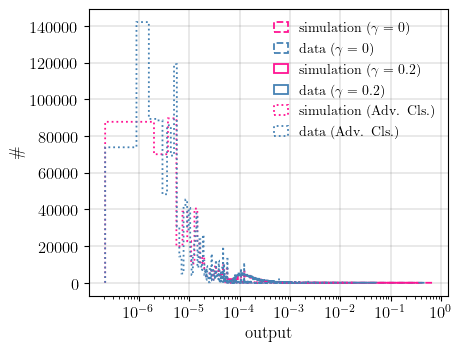

In [23]:
# make some plots
fsize = 12
fsize_annotate = 10

std_figsize = (1.2 * 3.7, 1.6 * 2.3617)
std_axes_form = [0.16, 0.15, 0.81, 0.76]

electron_color = (0.85, 0.39, 0.14)
positron_color = (0.16, 0.37, 0.65)
# ax_colors = "#CFCFCF"
ax_colors = "darkgrey"
text_color = "grey"

def std_fig(ax_form=std_axes_form, figsize=std_figsize, rasterized=False):
    rcparams = {
        "axes.labelsize": fsize,
        "xtick.labelsize": fsize,
        "ytick.labelsize": fsize,
        "figure.figsize": std_figsize,
        "legend.frameon": False,
        "legend.loc": "best",
    }
    plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"
    rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
    rc("text", usetex=True)
    rcParams.update(rcparams)
    mpl.rcParams["hatch.linewidth"] = 0.25
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_axes(ax_form, rasterized=rasterized)
    ax.patch.set_alpha(0.0)

    return fig, ax

fig, ax = std_fig()
BINS = 10000
WIDTH = 0.6
LW = 1.3

kwargs = {
    "lw": LW,
    "linestyle": "--",
    "histtype": "step",
    "rwidth": WIDTH,
    "facecolor": "deeppink",
}
kwargs["label"] = r"simulation ($\gamma=0$)"
ax.hist(
    agreement_probs_NN[agreement_signal == 0][:,1],
    bins=BINS,
    density=True,
    weights=agreement_weight[agreement_signal == 0],
    edgecolor="deeppink",
    **kwargs
)
kwargs["label"] = r"data ($\gamma=0$)"
ax.hist(
    agreement_probs_NN[agreement_signal == 1][:,1],
    bins=BINS,
    density=True,
    weights=agreement_weight[agreement_signal == 1],
    edgecolor="steelblue",
    **kwargs
)

kwargs = {
    "lw": LW,
    "histtype": "step",
    "rwidth": WIDTH,
    "facecolor": "deeppink",
}
kwargs["label"] = r"simulation ($\gamma=0.2$)"
ax.hist(
    agreement_probs_BMI[agreement_signal == 0][:,1],
    bins=BINS,
    density=True,
    weights=agreement_weight[agreement_signal == 0],
    edgecolor="deeppink",
    **kwargs
)
kwargs["label"] = r"data ($\gamma=0.2$)"
ax.hist(
    agreement_probs_BMI[agreement_signal == 1][:,1],
    bins=BINS,
    density=True,
    weights=agreement_weight[agreement_signal == 1],
    edgecolor="steelblue",
    **kwargs
)

kwargs = {
    "lw": LW,
    "linestyle": ":",
    "histtype": "step",
    "rwidth": WIDTH,
    "facecolor": "deeppink",
}
kwargs["label"] = r"simulation (Adv. Cls.)"
ax.hist(
    agreement_probs_DCls[agreement_signal == 0].reshape(-1),
    bins=BINS,
    density=True,
    weights=agreement_weight[agreement_signal == 0],
    edgecolor="deeppink",
    **kwargs
)
kwargs["label"] = r"data (Adv. Cls.)"
ax.hist(
    agreement_probs_DCls[agreement_signal == 1].reshape(-1),
    bins=BINS,
    density=True,
    weights=agreement_weight[agreement_signal == 1],
    edgecolor="steelblue",
    **kwargs
)

ax.set_xlabel(r"output", fontsize=12)
ax.set_ylabel(r"\#", fontsize=12)
ax.grid(alpha=1, lw=0.25, zorder=-10, color="grey")
ax.set_xscale("log")

leg1 = ax.legend(
    frameon=False,
    fontsize=10,
    ncol=1,
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
    loc="upper right",
)
plt.savefig("source_target.pdf")
plt.show()

In [153]:
# prepare correlation data
check_correlation_features = correlation.drop(['id', 'mass', 'SPDhits'], axis=1)
correlation_probs_BMI = BMI.predict_proba(check_correlation_features)
correlation_probs_NN = NN.predict_proba(check_correlation_features)

In [154]:
cvm_BMI = compute_cvm(correlation_probs_BMI[:,1], correlation['mass'])
cvm_NN = compute_cvm(correlation_probs_NN[:,1], correlation['mass'])
print ('CvM metric', cvm_BMI, cvm_BMI < 0.002)
print ('CvM metric', cvm_NN, cvm_NN < 0.002)

CvM metric 0.0008627846393993524 True
CvM metric 0.0008137530980162971 True


In [191]:
# performe some gamma experiments
trained_bmi = []
for gamma in np.linspace(0, 1, 20):
    BMI = BinaryMI(
        kernel_regularizer = 0.0,
        batch_size=32,
        hidden_layers = [64,32],
        quantized_position=[True, False],
        input_shape=(X_train.shape[1],),
        verbose=0,
        gamma=gamma,
        print_summary=False,
        last_layer_size=2,
        run_eagerly=False
    )
    train_hist_BMI = BMI.fit(x_train=X_train, y_train=y_train, s_train=S_train)
    trained_bmi.append(BMI)

In [192]:
# get evaluation
auc_list = []
ks_list = []
for bmi in trained_bmi:
    pre_bmi = bmi.predict_proba(X_test)
    agreement_probs_BMI = bmi.predict_proba(agreement_test_feature)
    auc_list.append(roc_auc_score(y_test, pre_bmi[:,1]))
    ks_list.append(compute_ks(
        agreement_probs_BMI[:,1][agreement_signal == 0],
        agreement_probs_BMI[:,1][agreement_signal == 1],
        agreement_weight[agreement_signal == 0],
        agreement_weight[agreement_signal == 1]
    ))

/var/folders/sd/hnbd9dm54xl_zh0fctx18ls40000gn/T/ipykernel_67096/3033064254.py:46: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("gamma.pdf")
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


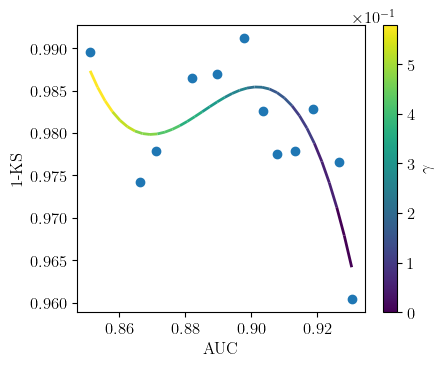

In [195]:
def get_color_line(x, y, z, ax_kwargs, s, linestyle='solid', norm=True):
    xnew = np.linspace(min(x), max(x), 3*len(z))
    cs = UnivariateSpline(x, y, s=s)
    ysmooth= cs(xnew)

    ax_kwargs.scatter(x, y, zorder=1)

    znew = []
    for v in z:
        for i in range(3):
            znew.append(v)
    x = xnew
    y = ysmooth
    z = znew

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    if norm:
        norm = plt.Normalize(min(z), max(z))
        lc = LineCollection(segments, cmap='viridis', norm=norm, linestyle=linestyle)
    else:
        lc = LineCollection(segments, cmap='viridis', linestyle=linestyle)

    # Set the values used for colormapping
    lc.set_array(z)
    lc.set_linewidth(2)
    line = ax_kwargs.add_collection(lc)
    return line

fig, ax = std_fig()
x = np.array(auc_list)
y = 1-np.array(ks_list)
z = np.linspace(0, 1, 20)

y = y[x>0.6]
z = z[x>0.6]
x = x[x>0.6]
x, y, z = zip(*sorted(zip(x, y, z)))
line = get_color_line(x, y, z, ax, s=0.1, linestyle="-", norm=False)

plt.xlabel("AUC")
plt.ylabel(f"1-KS")
cbar = fig.colorbar(line)
cbar.set_label(f"$\gamma$")
cbar.formatter.set_powerlimits((0, 0))
plt.savefig("gamma.pdf")
plt.show()

Simulation of the Bernoulli distribution
=====
```VHDL
library ieee;
use ieee.std_logic_1164.all;

entity linear_shift is
generic (
    g_min : positive := 174;
    g_max : positive := 1048509;
    g_m : positive := 20;
    g_poly : std_logic_vector := "11000000001100000000" -- x^7+x^6+1
);
port (
    i_sync_reset    : in    std_logic;
    i_seed          : in    std_logic_vector (g_m-1 downto 0);
    i_en            : in    std_logic;
    i_activation    : in    std_logic_vector (9 downto 0);
    o_bernoulli     : out   std_logic;
    o_lfsr          : out   std_logic_vector (g_m-1 downto 0);

    i_reset_n       : in    std_logic;
    i_clk           : in    std_logic--;
);
end entity;

architecture rtl of linear_shift is

    signal r_lfsr : std_logic_vector (g_m downto 1);
    signal w_mask : std_logic_vector (g_m downto 1);
    signal w_poly : std_logic_vector (g_m downto 1);

begin

    o_lfsr <= r_lfsr(g_m downto 1);
    w_poly <= g_poly;
    g_mask : for k in g_m downto 1 generate
        w_mask(k) <= w_poly(k) and r_lfsr(1);
    end generate;

    process(i_clk, i_reset_n)
    begin
    if ( i_reset_n /= '1' ) then
        r_lfsr <= (others => '1');
    elsif rising_edge(i_clk) then
        if ( i_sync_reset = '1' ) then
            r_lfsr <= i_seed;
        elsif (i_en = '1') then
            r_lfsr <= '0' & r_lfsr(g_m downto 2) xor w_mask;
        end if;
    end if;
    end process;

end architecture;
```

In [98]:
# run some analysis
def run_lfsr(w_poly, r_lfsr, g_m, i_seed, min_value=0, max_value=0, activation=0):
    bernoulli = []
    states = []
    counter = 0
    while True:
        # get the outer asignement first
        w_mask_list = []
        for bit in range(g_m):
            w_mask_list.append(((w_poly >> bit) & 1) and ((r_lfsr >> 1) & 1))
        w_mask = int("".join(map(str, reversed(w_mask_list))), 2)

        # do the actual shift
        r_lfsr = r_lfsr >> 1
        r_lfsr_list = []
        for bit in range(g_m):
            r_lfsr_list.append(((r_lfsr >> bit) & 1) ^ ((w_mask >> bit) & 1))
        r_lfsr = int("".join(map(str, reversed(r_lfsr_list))), 2)

        # sometimes we dont find a good LFSR then we stop
        if counter == 100000:
            break
        if r_lfsr == i_seed:
            break
        states.append(r_lfsr)

        counter += 1
        if max_value - min_value == 0: continue

        # we use a ROM here to get the pre-computed normed values 
        if activation <= ((r_lfsr - min_value) / (max_value - min_value)):
            bernoulli.append(0)
        else:
            bernoulli.append(1)

    return states, bernoulli

g_poly_list = [1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0]
i_seed_list = [0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
x = []
y = []
yerr = []
for i in range(7, 20):
    # set default values
    g_m = i
    g_poly = int("".join(map(str, g_poly_list[:i])), 2)
    w_poly = g_poly
    i_seed = int("".join(map(str, i_seed_list[:i])), 2)
    r_lfsr = i_seed

    # run the LFSR
    states, _ = run_lfsr(w_poly, r_lfsr, g_m, i_seed)
    xi = []
    yi = []
    zi = []
    for i in range(10):
        activation = random.uniform(0, 1)
        _, bernoulli = run_lfsr(w_poly, r_lfsr, g_m, i_seed, min(states), max(states), activation=activation)

        # run random generator
        bernoulli_random = []
        for i in states:
            if activation <= random.uniform(0, 1):
                bernoulli_random.append(0)
            else:
                bernoulli_random.append(1)
        xi.append(sum(bernoulli)/len(bernoulli))
        yi.append(sum(bernoulli_random)/len(bernoulli_random))
        zi.append(len(states))
    x.append(np.mean(zi))
    y.append(np.mean(np.array(xi)-np.array(yi)))
    yerr.append(np.std(np.array(xi)-np.array(yi)))

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


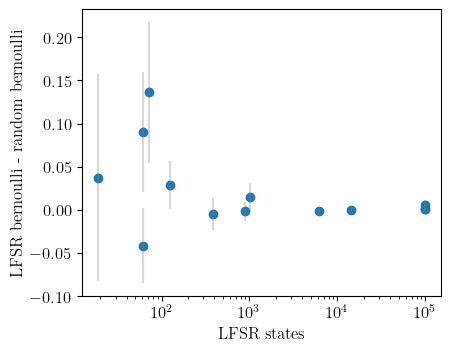

In [103]:
# plot
fig, ax = std_fig()

ax.scatter(x, y)
ax.errorbar(x, y, yerr=yerr, alpha=0.3, fmt='none', color="gray")
ax.set_xscale("log")

ax.set_xlabel(r"LFSR states", fontsize=12)
ax.set_ylabel(r"LFSR bernoulli - random bernoulli", fontsize=12)
plt.savefig("lfsr.pdf")
plt.show()